<h3>Import libraries</h3>

In [1]:
# Standard Library
import math

# Torch-related
import torch
import torchvision
import torchmetrics
import timm
import pytorch_lightning as pl

# General third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from PIL import Image

<h3>Config</h3>

In [2]:
class CFG:
    # General
    seed = 42

    # Data
    base_path = "/kaggle/input/planttraits2024"#"../data"
    image_size = [224, 224]
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    num_classes = len(class_names)
    aux_class_names = ['X4_sd', 'X11_sd', 'X18_sd',
                       'X26_sd', 'X50_sd', 'X3112_sd',]
    num_aux_classes = len(aux_class_names)
    feature_names = None
    num_features = 0
    
    # K-Fold
    num_folds = 5
    fold = 0

    # Model
    epochs = 1 # 12
    batch_size = 32 # 96
    lr_mode = "exp"
    profile = False
    inet_output_size = 1408

    # Loss
    y_mean = None
    eps = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
pl.seed_everything(CFG.seed, workers=True)

Device: cuda


42

<h3>Load and process data set</h3>

In [3]:
# Train + Valid
df = pd.read_csv(f'{CFG.base_path}/train.csv')
df['image_path'] = f'{CFG.base_path}/train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, CFG.aux_class_names] = df.loc[:, CFG.aux_class_names].fillna(-1)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{CFG.base_path}/test.csv')
test_df['image_path'] = f'{CFG.base_path}/test_images/'+test_df['id'].astype(str)+'.jpeg'
display(test_df.head(2))

CFG.feature_names = test_df.columns[1:-1].tolist()
CFG.num_features = len(CFG.feature_names)

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,/kaggle/input/planttraits2024/train_images/192...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,/kaggle/input/planttraits2024/train_images/195...


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path
0,201238668,8.086756,2246.500000,127.321426,20.423418,353.381042,17.535713,80,109,90,...,0.389460,0.387536,0.374910,0.363712,0.364623,0.379435,0.388294,0.398887,0.397853,/kaggle/input/planttraits2024/test_images/2012...
1,202310319,10.844286,495.871429,28.023809,18.738306,786.554382,29.292856,130,155,142,...,0.300813,0.332776,0.314386,0.291168,0.280947,0.277623,0.276503,0.271212,0.272672,/kaggle/input/planttraits2024/test_images/2023...


In [4]:
# Remove outliers
for col in CFG.class_names:
    lower_quantile = df[col].quantile(0.005)
    upper_quantile = df[col].quantile(0.985)
    df = df[(df[col] >= lower_quantile) & (df[col] <= upper_quantile)]

In [5]:
def build_augmenter():
    # Define augmentations
    aug_layers = torch.nn.ModuleList([
        torchvision.transforms.ColorJitter(brightness=0.1),
        torchvision.transforms.ColorJitter(contrast=0.1),
        torchvision.transforms.ColorJitter(saturation=(0.45, 0.55)),
        torchvision.transforms.ColorJitter(hue=0.1),
        torchvision.transforms.RandomErasing(scale=(0.06, 0.15)),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomResizedCrop(size=(CFG.image_size[0], CFG.image_size[1]), scale=(0.05, 0.15), antialias=True),
        torchvision.transforms.RandomRotation(degrees=(0.6, 3.0)), # Approx multiplied by 360/2pi since keras works in radians while this works in degrees
    ])
    
    # Build augmenter, randomly applying augmentations
    augmenter = torchvision.transforms.RandomApply(aug_layers, p=0.5)
                  
    # Apply augmentations
    def augment(inp, label=None):
        inp["images"] = augmenter(inp["images"])
        return inp, label
    return augment


def build_decoder(with_labels=True):
    def decode_image(inp):
        # Read jpeg image
        path = inp["images"]
        image = Image.open(path)

        # Resize and convert to tensor
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(CFG.image_size),
            torchvision.transforms.ToTensor(),
        ])
        image = transform(image)
        
        # Rescale image
        image = image.float()
        image /= 255.0
        
        # Insert decoded image and return
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = torch.tensor(label).float()
        label = label.view(num_classes)
        return label

    def decode_with_labels(inp, labels):
        inp = decode_image(inp)
        label = decode_label(labels[0], CFG.num_classes)
        aux_label = decode_label(labels[1], CFG.num_aux_classes)
        return (inp, (label, aux_label))

    return decode_with_labels if with_labels else decode_image

class INetDataset(torch.utils.data.Dataset):
    def __init__(self, paths, features, labels=None, aux_labels=None, decode_fn=None, augment_fn=None):
        self.paths = paths
        self.features = features
        self.labels = labels
        self.aux_labels = aux_labels
        self.decode_fn = decode_fn
        self.augment_fn = augment_fn

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        inp = {"images": self.paths[idx], "features": self.features[idx]}
        if self.labels is not None:
            slices = self.decode_fn(inp, (self.labels[idx], self.aux_labels[idx]))
            if self.augment_fn is not None:
                slices = self.augment_fn(inp, (self.labels[idx], self.aux_labels[idx]))
        else:
            slices = self.decode_fn(inp)
            if self.augment_fn is not None:
                slices = self.augment_fn(inp)

        return slices

def build_dataset(
    paths,
    features,
    labels=None,
    aux_labels=None,
    batch_size=32,
    augment=False,
    shuffle=False,
):
    decode_fn = build_decoder(labels is not None or aux_labels is not None)
    augment_fn = build_augmenter() if augment else None
    dataset = INetDataset(paths, features, labels, aux_labels, decode_fn, augment_fn)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [6]:
skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)

# Create separate bin for each traits
for i, trait in enumerate(CFG.class_names):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, CFG.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

# Concatenate the bins into a final bin
df["final_bin"] = (
    df[[f"bin_{i}" for i in range(len(CFG.class_names))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
df = df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [7]:
# Sample from full data
sample_df = df.copy()
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[CFG.feature_names].values)
valid_features = scaler.transform(valid_df[CFG.feature_names].values)

# Train
train_paths = train_df.image_path.values
train_labels = train_df[CFG.class_names].values
train_aux_labels = train_df[CFG.aux_class_names].values
train_ds = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=CFG.batch_size,
                         shuffle=True, augment=True)

# Valid
valid_paths = valid_df.image_path.values
valid_labels = valid_df[CFG.class_names].values
valid_aux_labels = valid_df[CFG.aux_class_names].values
valid_ds = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=CFG.batch_size,
                         shuffle=False, augment=False)


# Num Train: 39336 | Num Valid: 9834


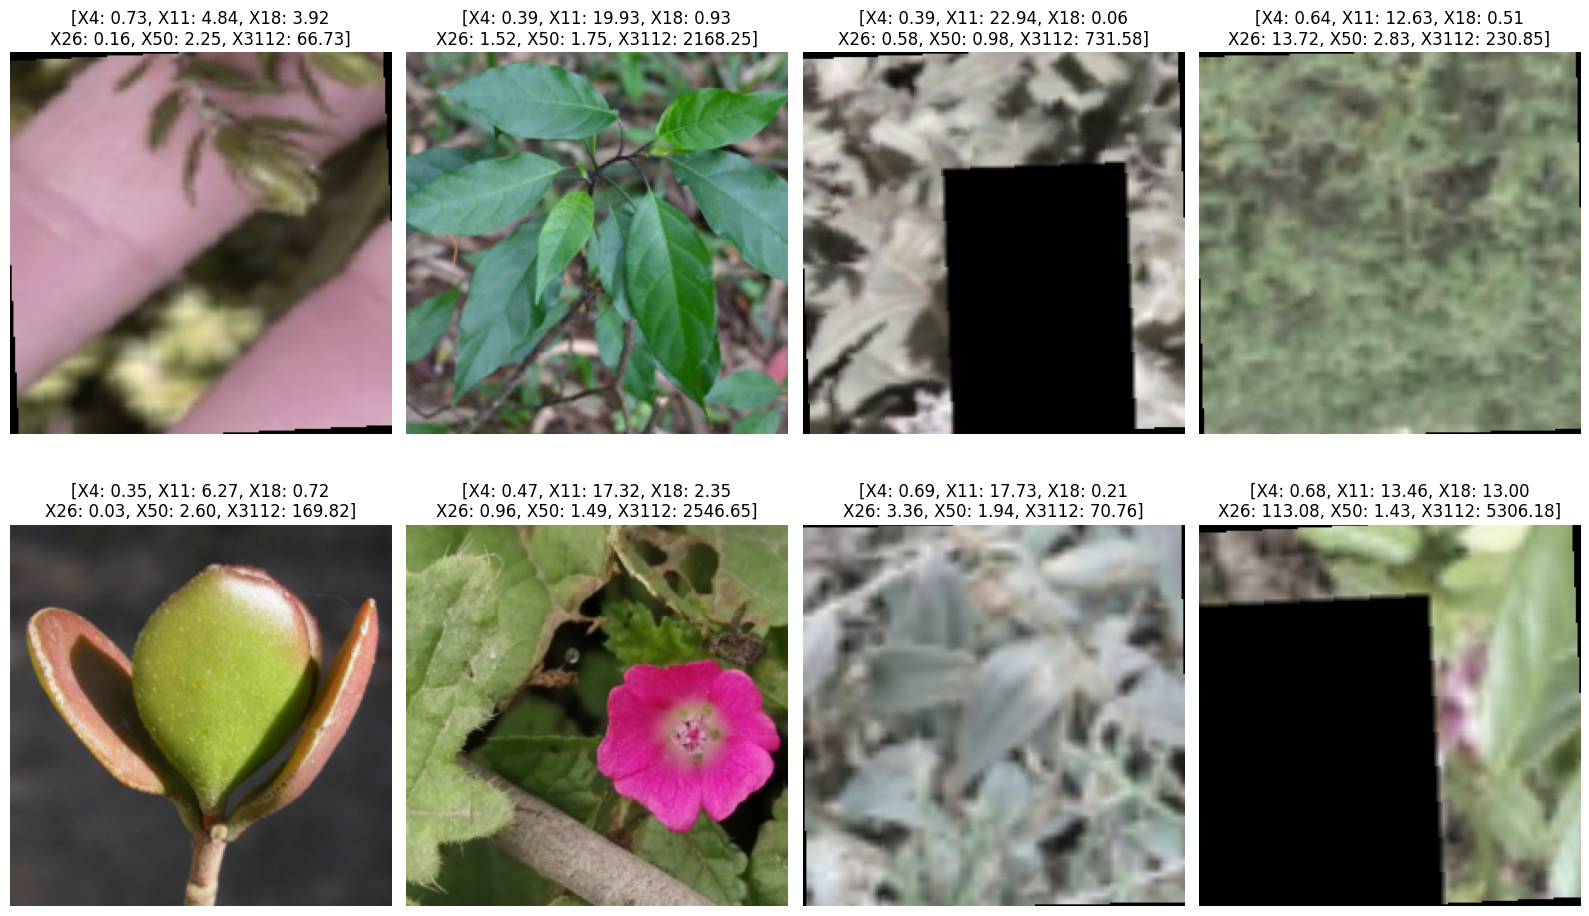

In [8]:
# Get a sample of the data
inps, tars = next(iter(train_ds))
imgs = inps["images"]

# Plot the first eight images of the sample with their labels
num_imgs, num_cols = 8, 4
plt.figure(figsize=(4 * num_cols, num_imgs // num_cols * 5))
for i, (img, tar) in enumerate(zip(imgs[:num_imgs], tars[0][:num_imgs])):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)

    img = img.permute(1, 2, 0)  # Change (C, H, W) to (H, W, C)
    
    img = img.numpy()
    tar = tar.numpy()
    
    img = (img - img.min()) / (img.max() + 1e-4)

    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(CFG.class_names[j : j + 3], tar[j : j + 3])
            )
            for j in range(0, len(CFG.class_names), 3)
        ]
    )


    plt.imshow(img)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")

plt.tight_layout()
plt.show()

<h3>Define loss</h3>

In [9]:
CFG.y_mean = torch.tensor(train_df[CFG.class_names].mean(axis=0).values).to(device)
CFG.eps = torch.tensor([1e-6]).to(device)

class R2Loss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_true, y_pred):
        ss_res = torch.sum((y_true - y_pred)**2, dim=0)
        ss_total = torch.sum((y_true - CFG.y_mean)**2, dim=0)
        ss_total = torch.maximum(ss_total, CFG.eps)
        r2 = torch.mean(ss_res / ss_total)
        return r2

class R2Metric(torchmetrics.Metric):
    def __init__(self):
        super().__init__()
        self.add_state("rss", default=torch.zeros(CFG.num_classes).to(device), dist_reduce_fx="sum")
        self.add_state("tss", default=torch.zeros(CFG.num_classes).to(device), dist_reduce_fx="sum")

    def update(self, y_true, y_pred):
        self.rss.add_(torch.sum((y_true - y_pred) ** 2, dim=0))
        self.tss.add_(torch.sum((y_true - CFG.y_mean) ** 2, dim=0))

    def compute(self):
        ss_total = torch.maximum(self.tss, CFG.eps)
        r2 = torch.mean(self.rss / ss_total)
        return r2

<h3>Construct model</h3>

In [10]:
def search_timm_model(query):
    search_result = [n for n in timm.list_models(pretrained=True) if query in n]
    for i, name in enumerate(search_result):
        print(f'{i:02d} | {name}')
        
#search_timm_model('resnet50.b2')

In [11]:
class INet(torch.nn.Module):
    def __init__(self):
        super(INet, self).__init__()
        self.backbone = timm.create_model(
                'efficientnet_b2',
                pretrained=True,
                num_classes=0,
            )
        self.dropout1 = torch.nn.Dropout(0.2)
        self.fc1 = torch.nn.Linear(CFG.inet_output_size, CFG.num_classes)

        self.dense = torch.nn.Sequential(
            torch.nn.Linear(CFG.num_features, 326),
            torch.nn.SELU(),
            torch.nn.Linear(326, 64),
            torch.nn.SELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(64, CFG.num_aux_classes)
        )

    def forward(self, images, features):
        x1 = self.backbone(images)
        x1 = self.dropout1(x1)
        x1 = self.fc1(x1)

        features = features.to(torch.float32)
        x2 = self.dense(features)

        return {"head": x1, "aux_head": x2}

model = INet()
model.to(device)

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

INet(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), 

<h3>LR Scheduler</h3>

In [12]:
def get_lr_scheduler(optimizer):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * CFG.batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: 
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: 
            lr = lr_max
        elif CFG.lr_mode == 'exp': 
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif CFG.lr_mode == 'step': 
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif CFG.lr_mode == 'cos':
            decay_total_epochs = CFG.epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lrfn)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = get_lr_scheduler(optimizer)

<h3>Training</h3>

In [13]:
def train_epoch(model, train_ds, optimizer, loss_fn_head, loss_fn_aux_head, device):
    model.train()
    for inp, (labels, aux_labels) in tqdm(train_ds):
        optimizer.zero_grad()
        labels = labels.to(device)
        aux_labels = aux_labels.to(device)
        images = inp["images"].to(device)
        features = inp["features"].to(device)

        outputs = model(images, features)
        loss_head = loss_fn_head(outputs["head"], labels)
        loss_aux_head = loss_fn_aux_head(outputs["aux_head"], aux_labels)
        loss = loss_head
        loss += 0.3 * loss_aux_head
        loss.backward()
        optimizer.step()
    
    print(f"Loss: {loss.item():.4f}")

# Initialize best R2 and best epoch
best_R2 = -np.inf
best_epoch = -1

# Initialize loss functions
loss_fn_head = R2Loss().to(device)
loss_fn_aux_head = R2Loss().to(device)

# Training loop
for epoch in range(CFG.epochs):
    print(f"Epoch: {epoch+1} | LR: {optimizer.param_groups[0]['lr']:0.10f}")

    try:
        if CFG.profile:
            with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA], record_shapes=False, with_stack=False, profile_memory=False, with_flops=False) as prof:
                with torch.profiler.record_function("model_training"):
                        train_epoch(model, train_ds, optimizer, loss_fn_head, loss_fn_aux_head, device)
        else:
            train_epoch(model, train_ds, optimizer, loss_fn_head, loss_fn_aux_head, device)
    except RuntimeError as e:
        if str(e).startswith("mat1 and mat2 shapes cannot be multiplied"):
            raise ValueError(f"Wrong output size for the imagenet in config (CFG.inet_output_size): should be {str(e).split('x')[1].split(' ')[0]} but is {CFG.inet_output_size}.")
        else:
            raise RuntimeError(e)

    # Update learning rate
    scheduler.step()

    # Calculate R2 score on validation set
    with torch.no_grad():
        model.eval()
        outputs = [model(inp["images"].to(device), inp["features"].to(device)) for inp, _ in tqdm(valid_ds)]
        preds = torch.cat([o["head"] for o in outputs])
        labels = torch.cat([labels[1] for _, labels in valid_ds])
        R2 = R2Metric().to(device)
        R2 = R2(preds.to(device), labels.to(device))

    # Update best R2 and best epoch
    if R2 > best_R2:
        best_R2 = R2
        best_epoch = epoch

    print(f"R2: {R2:.4f} | Best R2: {best_R2:.4f} (epoch {best_epoch+1})")


# Print profiler results
if CFG.profile:
    print(prof.key_averages().table(sort_by="cuda_time_total"))

Epoch: 1 | LR: 0.0000000500


  0%|          | 0/1230 [00:00<?, ?it/s]

Loss: 1.0257


  0%|          | 0/308 [00:00<?, ?it/s]

R2: 0.3421 | Best R2: 0.3421 (epoch 1)


<h3>Results</h3>

In [14]:
# Best Result
print("#" * 10 + " Result " + "#" * 10)
print(f"Best R2: {best_R2:.5f}")
print(f"Best Epoch: {best_epoch}")
print("#" * 28)

########## Result ##########
Best R2: 0.34213
Best Epoch: 0
############################


In [15]:
# Test
test_paths = test_df.image_path.values
test_features = scaler.transform(test_df[CFG.feature_names].values)
test_ds = build_dataset(test_paths, test_features, batch_size=CFG.batch_size,
                        shuffle=False, augment=False)

preds = []
for inp in tqdm(test_ds):
    with torch.no_grad():
        batch_preds = model(inp["images"].to(device), inp["features"].to(device))["head"]
        preds.append(batch_preds)

# Concatenate all predictions
preds = torch.cat(preds)

  0%|          | 0/205 [00:00<?, ?it/s]

In [16]:
pred_df = test_df[["id"]].copy()
target_cols = [x.replace("_mean","") for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

pred_df.to_csv("submission.csv", index=False)
pred_df.head()

,id,X4,X11,X18,X26,X50,X3112
0,201238668,0.007425,0.257854,0.242954,-0.137333,0.168541,-0.239366
1,202310319,-0.273984,0.014419,-0.304076,-0.071535,0.188272,-0.120577
2,202604412,0.119060,-0.020077,0.057451,0.256325,0.251713,0.167301
3,201353439,-0.017935,-0.071359,0.290323,-0.455406,0.027642,-0.139075
4,195351745,0.102600,0.111254,-0.165820,0.221170,0.021410,-0.168234
